# Combining Datasets & Pivot Tables with Pandas

## Learning Objectives

At the end of this notebook you should be able to
- combine DataFrames with Pandas
- describe the different joining methods (how to join DataFrames)
- create pivot tables with Pandas
- clone ("copy") conda environments

Pandas functions that allow us to combine two sets of data include the use of `pd.merge()`, `df.join()`, `df.merge()`, and `pd.concat()`. For the most part, these do largely the same things (although you'll notice the slight syntax difference with `merge()` and `concat()` being able to be called via the Pandas module and `merge()` and `join()` being able to be called on a DataFrame instance).   
There are some cases where one of these might be better than another in terms of writing less code or performing some kind of data combination in an easier way. The major differences between these, though, largely depend on what they do by default when you try to combine different data. By default, `merge()` looks to join on common columns, `join()` on common indices, and `concat()` by just appending on a given axis.

You can find more detail about the differences between all three of these in the [docs](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html). We'll look at some examples below. 

## But first: cloning your environment

Why's that?  
In this notebook we want to use the GeoPandas package, which is based on an _open source project to add support for geographic data to pandas objects._ - in brief: we will have a dataframe with an additional geometric datatype.  

Since we usually don't need packages for geospatial data, we don't want to load it everytime we activate our usual nf_base environment.  
The good thing is:  
In conda, it is possible to easily copy, or better, clone an existing environment,  
so we will make use of this, create a new environment called _nf_geo_ based on _nf_base_, add the GeoPandas package to it and then use this new environment for this notebook.

To do so, use your terminal and clone your nf_base environment:  

    $ conda create --clone nf_base --name nf_geo

Afterwards, activate the environment  

    $ conda activate nf_geo  

Since GeoPandas is available via the conda forge, so you may have to enable this channel first:  

    $ conda config --add channels conda-forge
    $ conda config --set channel_priority flexible  
    
then install the package:  

    $ conda install -c conda-forge geopandas


Now, we import our needed modules for this notebook:

In [1]:
# standard import of pandas
import pandas as pd

# additional import of the geopandas package
import geopandas as gpd

# numpy, "numerical python" - we'll cover this in the following notebooks.
import numpy as np

# hides warning messages
import warnings
warnings.filterwarnings("ignore")

## Loading the first dataset
The data we'll use is data on bicycle theft crimes at the granular level of Berlin city planning areas, so-called "LOR" - "Lebensweltlich orientierte Räume", we will stumble over it again later!  
This data is provided by Berlin Open Data and collected by the police of Berlin.  

### The goal is to be able to identify areas in Berlin with the most bike thefts or the highest theft amounts  

But first things first: We make the data accessible just by loading the .csv-file into a dataframe and get an overview.

[Website to datatset -  daten.berlin.de](https://daten.berlin.de/datensaetze/fahrraddiebstahl-berlin)

- Licence:
    - Creative Commons Namensnennung CC-BY License
- Geographical Granularity: 
    - Berlin
- Publisher: 
    - Polizei Berlin LKA St 14
- E Mail: 
    - onlineredaktion@polizei.berlin.de

In [2]:
thefts_df = pd.read_csv('data/Fahrraddiebstahl.csv', encoding='latin-1') # proper encoding is necessary here!
thefts_df.columns = thefts_df.columns.str.lower()  # make column names lowercase
thefts_df.head(2)

,angelegt_am,tatzeit_anfang_datum,tatzeit_anfang_stunde,tatzeit_ende_datum,tatzeit_ende_stunde,lor,schadenshoehe,versuch,art_des_fahrrads,delikt,erfassungsgrund
0,14.09.2020,10.09.2020,10,10.09.2020,12,3400723,706,Nein,Damenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
1,29.09.2020,09.09.2020,16,10.09.2020,7,9200716,220,Nein,Damenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern


In [3]:
# what's the shape, the observations, datatypes and null-counts?
thefts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39407 entries, 0 to 39406
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   angelegt_am            39407 non-null  object
 1   tatzeit_anfang_datum   39407 non-null  object
 2   tatzeit_anfang_stunde  39407 non-null  int64 
 3   tatzeit_ende_datum     39407 non-null  object
 4   tatzeit_ende_stunde    39407 non-null  int64 
 5   lor                    39407 non-null  int64 
 6   schadenshoehe          39407 non-null  int64 
 7   versuch                39407 non-null  object
 8   art_des_fahrrads       39407 non-null  object
 9   delikt                 39407 non-null  object
 10  erfassungsgrund        39407 non-null  object
dtypes: int64(4), object(7)
memory usage: 3.3+ MB


Let's quickly think about cleaning our data:

- drop duplicates? inspect!
- drop column 'angelegt_am' and 'erfassungsgrund' - irrelevant to us
- column 'versuch': inspect!  
- column 'tatzeit_anfang_datum': change date string to datetime format  
- column 'tatzeit_anfang_ende': change date string to datetime format

In [4]:
# inspect duplicates
thefts_df[thefts_df.duplicated(keep=False)].sort_values(by=['tatzeit_anfang_datum', 'schadenshoehe']).tail(6)

,angelegt_am,tatzeit_anfang_datum,tatzeit_anfang_stunde,tatzeit_ende_datum,tatzeit_ende_stunde,lor,schadenshoehe,versuch,art_des_fahrrads,delikt,erfassungsgrund
29789,01.09.2020,31.08.2020,18,01.09.2020,0,1400940,220,Nein,Mountainbike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
29866,01.09.2020,31.08.2020,18,01.09.2020,0,1400940,220,Nein,Mountainbike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
16188,01.09.2021,31.08.2021,16,31.08.2021,17,2400623,3900,Nein,Damenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
16189,01.09.2021,31.08.2021,16,31.08.2021,17,2400623,3900,Nein,Damenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
12041,02.11.2020,31.10.2020,18,02.11.2020,8,10100312,299,Nein,Damenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
12045,02.11.2020,31.10.2020,18,02.11.2020,8,10100312,299,Nein,Damenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern


In [5]:
# the specifications of the duplicates indicate that they are implausible, so we drop them.
# drop duplicates (rows by default)
thefts_df.drop_duplicates(inplace=True)

In [6]:
# drop column 'angelegt_am' and 'erfassungsgrund' - irrelevant to us, when and why observation got added to the database.
thefts_df.drop(columns='angelegt_am', inplace=True)
thefts_df.drop(columns='erfassungsgrund', inplace=True)


In [7]:
# how many unique values holds the column of the attempts?
thefts_df.versuch.unique()

array(['Nein', 'Ja', 'Unbekannt'], dtype=object)

In [8]:
# and what is the count of those categories?
thefts_df.versuch.value_counts()

Nein         39137
Ja             167
Unbekannt        7
Name: versuch, dtype: int64

In [9]:
# we have just 167 attempts and 7 thefts of unknown state in our dataset, so we decide to drop those observations.
thefts_df = thefts_df[thefts_df.versuch != 'Ja']
thefts_df = thefts_df[thefts_df.versuch != 'Unbekannt']

In [10]:
# change date text string to datetime datatype
thefts_df['tatzeit_anfang_datum'] = pd.to_datetime(thefts_df['tatzeit_anfang_datum'])
thefts_df['tatzeit_ende_datum'] = pd.to_datetime(thefts_df['tatzeit_ende_datum'])


In [11]:
# now that the dates are not only strings anymore, we can have a look at the timeframe
thefts_df.tatzeit_anfang_datum.min(), thefts_df.tatzeit_ende_datum.max()

(Timestamp('2020-01-01 00:00:00'), Timestamp('2021-12-11 00:00:00'))

In [12]:
# ... or can even do calculations on the date fields
thefts_df.tatzeit_ende_datum.max() - thefts_df.tatzeit_anfang_datum.min()

Timedelta('710 days 00:00:00')

In [13]:
# confirm the new datatypes
thefts_df[['tatzeit_anfang_datum', 'tatzeit_ende_datum']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39137 entries, 0 to 39406
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   tatzeit_anfang_datum  39137 non-null  datetime64[ns]
 1   tatzeit_ende_datum    39137 non-null  datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 917.3 KB


Now that we're done cleaning our dataset, the idea is to impute it by using categorical data to so called "dummy variables".  
Such a variable (aka indicator variable) is a numeric variable representing categorical data by giving each category an own column and assign a 0 or 1 to it.  

We'll use this on the "Art des Fahrrads" column, the type of bike.

In [14]:
# A glance at the values of the type of bikes in the dataframe
thefts_df.art_des_fahrrads.unique()

array(['Damenfahrrad', 'Herrenfahrrad', 'Fahrrad', 'Kinderfahrrad',
       'Rennrad', 'Mountainbike', 'diverse Fahrräder', 'Lastenfahrrad'],
      dtype=object)

In [15]:
# get_dummies is a method called on the pandas module - you simply pass in a Pandas Series 
# or DataFrame, and it will convert a categorical variable into dummy/indicator variables. 
# The idea of dummy coding is to convert each category into a new column, and assign a 1 or 0 to the column.
# This can be an important step during data preparation for machine learning.

# creating a dataset of type of bike dummy variables.
biketype_dummies = pd.get_dummies(thefts_df.art_des_fahrrads, prefix='type')
biketype_dummies.head()

,type_Damenfahrrad,type_Fahrrad,type_Herrenfahrrad,type_Kinderfahrrad,type_Lastenfahrrad,type_Mountainbike,type_Rennrad,type_diverse Fahrräder
0,1,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0
3,0,0,1,0,0,0,0,0
4,0,1,0,0,0,0,0,0


## Combining dataframes

### Join()
Now let's look at the `join()` method. It joins on indices by default and is called on a dataframe instance. This means that we can simply join our bike type dummies dataframe back to our original bike thefts dataframe with the following code:

In [16]:
# Joining columns of another DataFrame using the join() method.
join_df = thefts_df.join(biketype_dummies)
join_df.head()

,tatzeit_anfang_datum,tatzeit_anfang_stunde,tatzeit_ende_datum,tatzeit_ende_stunde,lor,schadenshoehe,versuch,art_des_fahrrads,delikt,type_Damenfahrrad,type_Fahrrad,type_Herrenfahrrad,type_Kinderfahrrad,type_Lastenfahrrad,type_Mountainbike,type_Rennrad,type_diverse Fahrräder
0,2020-10-09,10,2020-10-09,12,3400723,706,Nein,Damenfahrrad,Fahrraddiebstahl,1,0,0,0,0,0,0,0
1,2020-09-09,16,2020-10-09,7,9200716,220,Nein,Damenfahrrad,Fahrraddiebstahl,1,0,0,0,0,0,0,0
2,2020-10-09,15,2020-10-09,18,6100207,550,Nein,Herrenfahrrad,Fahrraddiebstahl,0,0,1,0,0,0,0,0
3,2020-10-09,20,2020-10-09,21,1300733,548,Nein,Herrenfahrrad,Fahrraddiebstahl,0,0,1,0,0,0,0,0
4,2020-09-09,22,2020-10-09,11,8100207,700,Nein,Fahrrad,Fahrraddiebstahl,0,1,0,0,0,0,0,0


In [17]:
# Let's have a look at the columns of our newly assigned dataframe
join_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39137 entries, 0 to 39406
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   tatzeit_anfang_datum    39137 non-null  datetime64[ns]
 1   tatzeit_anfang_stunde   39137 non-null  int64         
 2   tatzeit_ende_datum      39137 non-null  datetime64[ns]
 3   tatzeit_ende_stunde     39137 non-null  int64         
 4   lor                     39137 non-null  int64         
 5   schadenshoehe           39137 non-null  int64         
 6   versuch                 39137 non-null  object        
 7   art_des_fahrrads        39137 non-null  object        
 8   delikt                  39137 non-null  object        
 9   type_Damenfahrrad       39137 non-null  uint8         
 10  type_Fahrrad            39137 non-null  uint8         
 11  type_Herrenfahrrad      39137 non-null  uint8         
 12  type_Kinderfahrrad      39137 non-null  uint8 

The arguments of `.join` are the following: 
````
DataFrame.join(other, on=None, how='left', lsuffix='', rsuffix='', sort=False)
````
The documentation refers to the second dataframe as 'other', which the documentations of the other combining methods often refer to as 'right'.  
With `how` we can specify which join method we want to use.

If we want to join using a common column, we need to set this column to be the index in both dataframes. The joined DataFrame will have the common column as its index.

```
df.set_index('column_name').join(other.set_index('column_name'))
```

Another option to join using a common column is to use the on parameter. This method preserves the original DataFrame’s index in the result.
```
df.join(other.set_index('column_name'), on='column_name')
```
See the documentation [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.join.html).

The how argument to merge specifies which keys are included in the resulting table. If a key combination does not appear in either the left or right tables, the values in the joined table will be NA. Here is a summary of the how options and their SQL equivalent names:

Merge method | SQL Join Name | Description
---|---|---
left| LEFT OUTER JOIN | Use keys from left frame only
right | RIGHT OUTER JOIN | Use keys from right frame only
outer | FULL OUTER JOIN | Use union of keys from both frames
inner | INNER JOIN | Use intersection of keys from both frames


You can also think of it as set theory and use Venn diagrams to illustrate what happens in each method.

![Join Methods](./images/join_types.png)

### Merge()
Let's look at the `merge()` method. Merge combines dataframes on column columns by default and can be used via the pandas module AND called on a dataframe instance.

The arguments of `.merge` are the following: 
````
DataFrame.merge(right, how='inner', on=None, left_on=None, right_on=None, left_index=False, right_index=False, sort=False,   
suffixes=('_x', '_y'), copy=True, indicator=False, validate=None)
````
See the documentation [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html).

In [18]:
# Since in both dataframes, we need a common column.
# Let's use the index column as the one to merge on:
thefts_df_ind = thefts_df.reset_index()
biketype_dummies_ind = biketype_dummies.reset_index()

In [19]:
# check result - you will see a new column called index in the dataframe
thefts_df_ind.head()

,index,tatzeit_anfang_datum,tatzeit_anfang_stunde,tatzeit_ende_datum,tatzeit_ende_stunde,lor,schadenshoehe,versuch,art_des_fahrrads,delikt
0,0,2020-10-09,10,2020-10-09,12,3400723,706,Nein,Damenfahrrad,Fahrraddiebstahl
1,1,2020-09-09,16,2020-10-09,7,9200716,220,Nein,Damenfahrrad,Fahrraddiebstahl
2,2,2020-10-09,15,2020-10-09,18,6100207,550,Nein,Herrenfahrrad,Fahrraddiebstahl
3,3,2020-10-09,20,2020-10-09,21,1300733,548,Nein,Herrenfahrrad,Fahrraddiebstahl
4,4,2020-09-09,22,2020-10-09,11,8100207,700,Nein,Fahrrad,Fahrraddiebstahl


In [20]:
# check result - you will see a new column called index in the dataframe
biketype_dummies_ind.head()

,index,type_Damenfahrrad,type_Fahrrad,type_Herrenfahrrad,type_Kinderfahrrad,type_Lastenfahrrad,type_Mountainbike,type_Rennrad,type_diverse Fahrräder
0,0,1,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0
2,2,0,0,1,0,0,0,0,0
3,3,0,0,1,0,0,0,0,0
4,4,0,1,0,0,0,0,0,0


In [21]:
# Merge the quality_dummies df on the thefts_df instance on the common column 'index'
merge_df1 = thefts_df_ind.merge(biketype_dummies_ind, on='index')
merge_df1.head()

,index,tatzeit_anfang_datum,tatzeit_anfang_stunde,tatzeit_ende_datum,tatzeit_ende_stunde,lor,schadenshoehe,versuch,art_des_fahrrads,delikt,type_Damenfahrrad,type_Fahrrad,type_Herrenfahrrad,type_Kinderfahrrad,type_Lastenfahrrad,type_Mountainbike,type_Rennrad,type_diverse Fahrräder
0,0,2020-10-09,10,2020-10-09,12,3400723,706,Nein,Damenfahrrad,Fahrraddiebstahl,1,0,0,0,0,0,0,0
1,1,2020-09-09,16,2020-10-09,7,9200716,220,Nein,Damenfahrrad,Fahrraddiebstahl,1,0,0,0,0,0,0,0
2,2,2020-10-09,15,2020-10-09,18,6100207,550,Nein,Herrenfahrrad,Fahrraddiebstahl,0,0,1,0,0,0,0,0
3,3,2020-10-09,20,2020-10-09,21,1300733,548,Nein,Herrenfahrrad,Fahrraddiebstahl,0,0,1,0,0,0,0,0
4,4,2020-09-09,22,2020-10-09,11,8100207,700,Nein,Fahrrad,Fahrraddiebstahl,0,1,0,0,0,0,0,0


In [22]:
# Or another way: Merge the two dataframes via the pandas module on the common column 'index'
merge_df2 = pd.merge(thefts_df_ind, biketype_dummies_ind, on='index')
merge_df2.head()

,index,tatzeit_anfang_datum,tatzeit_anfang_stunde,tatzeit_ende_datum,tatzeit_ende_stunde,lor,schadenshoehe,versuch,art_des_fahrrads,delikt,type_Damenfahrrad,type_Fahrrad,type_Herrenfahrrad,type_Kinderfahrrad,type_Lastenfahrrad,type_Mountainbike,type_Rennrad,type_diverse Fahrräder
0,0,2020-10-09,10,2020-10-09,12,3400723,706,Nein,Damenfahrrad,Fahrraddiebstahl,1,0,0,0,0,0,0,0
1,1,2020-09-09,16,2020-10-09,7,9200716,220,Nein,Damenfahrrad,Fahrraddiebstahl,1,0,0,0,0,0,0,0
2,2,2020-10-09,15,2020-10-09,18,6100207,550,Nein,Herrenfahrrad,Fahrraddiebstahl,0,0,1,0,0,0,0,0
3,3,2020-10-09,20,2020-10-09,21,1300733,548,Nein,Herrenfahrrad,Fahrraddiebstahl,0,0,1,0,0,0,0,0
4,4,2020-09-09,22,2020-10-09,11,8100207,700,Nein,Fahrrad,Fahrraddiebstahl,0,1,0,0,0,0,0,0


### Concat()

Let's now look at concat.
`````
pandas.concat(objs, axis=0, join='outer', ignore_index=False, keys=None, levels=None, names=None,    
verify_integrity=False, sort=False, copy=True)
`````
Different from join and merge, which by default operate on columns, concat can define whether to operate on columns or rows.

See the documentation [here](https://pandas.pydata.org/docs/reference/api/pandas.concat.html).

In [23]:
concat_df = pd.concat([biketype_dummies, thefts_df], axis=1)
concat_df.head()

,type_Damenfahrrad,type_Fahrrad,type_Herrenfahrrad,type_Kinderfahrrad,type_Lastenfahrrad,type_Mountainbike,type_Rennrad,type_diverse Fahrräder,tatzeit_anfang_datum,tatzeit_anfang_stunde,tatzeit_ende_datum,tatzeit_ende_stunde,lor,schadenshoehe,versuch,art_des_fahrrads,delikt
0,1,0,0,0,0,0,0,0,2020-10-09,10,2020-10-09,12,3400723,706,Nein,Damenfahrrad,Fahrraddiebstahl
1,1,0,0,0,0,0,0,0,2020-09-09,16,2020-10-09,7,9200716,220,Nein,Damenfahrrad,Fahrraddiebstahl
2,0,0,1,0,0,0,0,0,2020-10-09,15,2020-10-09,18,6100207,550,Nein,Herrenfahrrad,Fahrraddiebstahl
3,0,0,1,0,0,0,0,0,2020-10-09,20,2020-10-09,21,1300733,548,Nein,Herrenfahrrad,Fahrraddiebstahl
4,0,1,0,0,0,0,0,0,2020-09-09,22,2020-10-09,11,8100207,700,Nein,Fahrrad,Fahrraddiebstahl


In the images below, you can see the differences, if axis is set as 0 or 1.

**Concat with axis=0:**
![Concat Axis 0](./images/concat_axis_0.png)

---

**Concat with axis=1:**
![Concat Axis 1](./images/concat_axis_1.png)

(The pictures were part of [this](https://towardsdatascience.com/python-pandas-dataframe-join-merge-and-concatenate-84985c29ef78) blog post.)

---

## Check your understanding

1. Please join the two given dataframes (df1 and df2) along rows and merge with the third (df3) dataframe along the common column id.  
If any key combinations are not present, these should be filled with NaNs.


In [24]:
df1 = pd.DataFrame({
        'student_id': ['S1', 'S2', 'S3', 'S4', 'S5'],
         'name': ['Erika Raaf', 'Nadja Berens', 'Florentin Kleist', 'Dorothea Eibl', 'Gerhard Bihlmeier'], 
        'subject': ['Math', 'Biology', 'Biology', 'English', 'Philosophy']})
df2 = pd.DataFrame({
        'student_id': ['S6', 'S7', 'S8'],
        'name': ['Jens Hüls', 'Vera Kagan', 'Paula Brodersen'], 
        'subject': ['Math', 'Math', 'Social Science']})
df3 = pd.DataFrame({
        'student_id': ['S1', 'S2', 'S3', 'S4', 'S5', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13'],
        'marks': [23, 45, 12, 67, 21, 55, 33, 14, 56, 83, 88, 12]})

In [25]:
result_data = pd.concat([df1, df2])
final_merged_data = pd.merge(result_data, df3, on='student_id')
final_merged_data

,student_id,name,subject,marks
0,S1,Erika Raaf,Math,23
1,S2,Nadja Berens,Biology,45
2,S3,Florentin Kleist,Biology,12
3,S4,Dorothea Eibl,English,67
4,S5,Gerhard Bihlmeier,Philosophy,21
5,S7,Vera Kagan,Math,55
6,S8,Paula Brodersen,Social Science,33


2. You have received some weather data (temperature) of the last year. For each month the average temperature was measured, only for a few months the maximum temperature could be measured. Anyway, you want to combine these two data without losing any information.

(Extra question: Can you fill in the average max. Temperature for the missing values in the Column `Max TemperatureF`)

In [26]:
weather_mean_data = {'Mean TemperatureF': [53.1, 70., 34.93548387, 28.71428571, 32.35483871, 72.87096774, 70.13333333, 35., 62.61290323, 39.8, 55.4516129 , 63.76666667],
                     'Month': ['Apr', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep']}
weather_max_data = {'Max TemperatureF': [68, 89, 91, 84], 'Month': ['Jan', 'Apr', 'Jul', 'Oct']}

In [27]:
# combination of dictionaries
pd.merge(
    pd.DataFrame(weather_mean_data), 
    pd.DataFrame(weather_max_data), 
    on='Month', 
    how='outer')

# combination including fill of NaN by column mean
pd.merge(
    pd.DataFrame(weather_mean_data), 
    pd.DataFrame(weather_max_data), 
    on='Month', 
    how='outer').fillna(pd.DataFrame(weather_max_data)['Max TemperatureF'].mean())

,Mean TemperatureF,Month,Max TemperatureF
0,53.100000,Apr,89.0
1,70.000000,Aug,83.0
2,34.935484,Dec,83.0
3,28.714286,Feb,83.0
4,32.354839,Jan,68.0
5,72.870968,Jul,91.0
6,70.133333,Jun,83.0
7,35.000000,Mar,83.0
8,62.612903,May,83.0
9,39.800000,Nov,83.0


---

### More examples on combining dataframes

Remember we initially said, we for example wanted to be able to identify areas in Berlin with the most bike thefts?  
So far, we can't.  

We have a lot of features describing the actual bike thefts, but we have nothing to really spot the area where it happens. The only thing we have in our dataframe is this suspicious "LOR" - so we have to do some research on it, if and how we can use it ...  

The [dataset description](https://www.berlin.de/polizei/_assets/dienststellen/lka/datensatzbeschreibung.pdf) at Berlin Open Data tells us about the LOR column:
- Kennung des Planungsraums, 8-stellig
- Raumhierarchie lebensweltlich orientierte Räume (LOR) der Senatsverwaltung für Stadtentwicklung und
Wohnen

Wow. _Raumhierarchie lebensweltlich orientierte Räume_ - that's where you know you deal with authorities. 
Since we don't have any Ideas what that means, we google it and find, that at the Website of [stadtentwicklung.berlin.de](https://www.stadtentwicklung.berlin.de/planen/basisdaten_stadtentwicklung/lor/de/download.shtml) there are LOR associated vector data files, .shp "shapefiles". So we have a look at them, too ...


## Combining multiple data sources

We now access the shapefiles and try to combine them with our biketheft data.

In [28]:
# assign a geodataframe based on the shapefile
gdf = gpd.GeoDataFrame.from_file('data/LOR_SHP_2021/lor_plr.shp')
gdf.columns = gdf.columns.str.lower()
gdf.head(5)

,plr_id,plr_name,geometry
0,08401245,Frauenviertel,"POLYGON ((398530.482 5807357.873, 398569.146 5..."
1,08401244,Waßmannsdorfer Chaussee,"POLYGON ((397994.196 5806511.717, 397993.161 5..."
2,08401246,Waltersdorfer Chaussee Ost,"POLYGON ((398909.474 5806709.670, 398907.398 5..."
3,08401243,Alt-Rudow,"POLYGON ((399260.777 5809071.777, 399251.106 5..."
4,08401242,Zittauer Straße,"POLYGON ((397378.822 5808471.734, 397377.582 5..."


In [29]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 542 entries, 0 to 541
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   plr_id    542 non-null    object  
 1   plr_name  542 non-null    object  
 2   geometry  542 non-null    geometry
dtypes: geometry(1), object(2)
memory usage: 12.8+ KB


So we see, this gave us a dataframe with obviously the LOR as plr_id, the district name and the geometrical shape of the area as a Polygon.

##### Polygon? What was that again?

<img src="images/geometries.jpg" alt="geometries" width="500"/>


So, those polygons should give us areas of Berlin. Let's give it a try: 

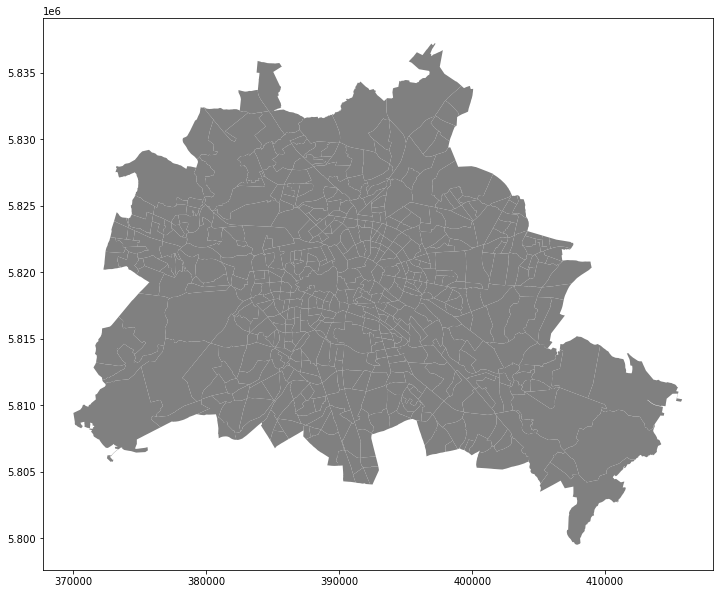

In [30]:
# plotting the geometries
gdf.plot(color='grey', figsize=(12, 12));

That somehow looks like Berlin which makes us quite confident to proceed to try to merge the sets, since our bike theft data is not yet inside our geodataframe (or vice versa) - those are still two seperate data sets.  

So - we need to have a look at the column that allow us to merge ...

In [31]:
# bike thefts lor column
thefts_df.lor.info()

<class 'pandas.core.series.Series'>
Int64Index: 39137 entries, 0 to 39406
Series name: lor
Non-Null Count  Dtype
--------------  -----
39137 non-null  int64
dtypes: int64(1)
memory usage: 1.6 MB


In [32]:
# geodataframe lor column
gdf.plr_id.info()

<class 'pandas.core.series.Series'>
RangeIndex: 542 entries, 0 to 541
Series name: plr_id
Non-Null Count  Dtype 
--------------  ----- 
542 non-null    object
dtypes: object(1)
memory usage: 4.4+ KB


Not that easy, again.  
- The column 'lor' in the bike theft data is an integer.  
- Integers as numeric values can't have leading zeros.  
- That's why it sometimes is 8 digits, sometimes is just 7 digits long - it then misses a leading 0 - we need to impute!  

In the geodataframe, the lor column is an object, which means a string in this case.  
Feel free to have a closer look ...

In [33]:
# changing the lor column datatype to string
thefts_df['lor_str'] = thefts_df['lor'].astype('str')

# fill leading gaps up to 8 characters with zeros and call the new column accordingly to the geodataframe
thefts_df['plr_id'] = thefts_df['lor_str'].apply(lambda x: x.zfill(8))

# dropping no longer needed columns
thefts_df.drop(columns=['lor', 'lor_str'], inplace=True)

thefts_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39137 entries, 0 to 39406
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   tatzeit_anfang_datum   39137 non-null  datetime64[ns]
 1   tatzeit_anfang_stunde  39137 non-null  int64         
 2   tatzeit_ende_datum     39137 non-null  datetime64[ns]
 3   tatzeit_ende_stunde    39137 non-null  int64         
 4   schadenshoehe          39137 non-null  int64         
 5   versuch                39137 non-null  object        
 6   art_des_fahrrads       39137 non-null  object        
 7   delikt                 39137 non-null  object        
 8   plr_id                 39137 non-null  object        
dtypes: datetime64[ns](2), int64(3), object(4)
memory usage: 4.0+ MB


In [34]:
# compare with the geodataframe
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 542 entries, 0 to 541
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   plr_id    542 non-null    object  
 1   plr_name  542 non-null    object  
 2   geometry  542 non-null    geometry
dtypes: geometry(1), object(2)
memory usage: 12.8+ KB


Now, we are able to merge our dataframes

In [35]:
# merging dataframes on the plr_id columns
gdf_biketheft = gdf.merge(thefts_df, on='plr_id')
gdf_biketheft.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 39137 entries, 0 to 39136
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   plr_id                 39137 non-null  object        
 1   plr_name               39137 non-null  object        
 2   geometry               39137 non-null  geometry      
 3   tatzeit_anfang_datum   39137 non-null  datetime64[ns]
 4   tatzeit_anfang_stunde  39137 non-null  int64         
 5   tatzeit_ende_datum     39137 non-null  datetime64[ns]
 6   tatzeit_ende_stunde    39137 non-null  int64         
 7   schadenshoehe          39137 non-null  int64         
 8   versuch                39137 non-null  object        
 9   art_des_fahrrads       39137 non-null  object        
 10  delikt                 39137 non-null  object        
dtypes: datetime64[ns](2), geometry(1), int64(3), object(5)
memory usage: 3.6+ MB


And so, we are finally able to infer infer the are with the most bikes stolen  
by aggregating count of thefts:

aggregating count of thefts

In [36]:
# counting thefts in areas
df_plr_group_thefts = gdf_biketheft.groupby(by='plr_id').size().reset_index(name='thefts')

# showing new dataframe with plr_id and aggregated count of thefts
df_plr_group_thefts.head()

,plr_id,thefts
0,01100101,71
1,01100102,148
2,01100103,117
3,01100104,102
4,01100205,43


aggregating average theft amounts

In [37]:
# counting thefts in areas
df_plr_group_mean = gdf_biketheft.groupby(by='plr_id').mean().reset_index()
df_plr_group_mean = df_plr_group_mean[['plr_id', 'schadenshoehe']]
df_plr_group_mean = df_plr_group_mean.astype({'schadenshoehe': 'int64'})
df_plr_group_mean.rename(columns={'schadenshoehe': 'avg_amount'}, inplace=True)

# showing new dataframe with plr_id and aggregated mean of thefts
df_plr_group_mean.head()

,plr_id,avg_amount
0,01100101,1026
1,01100102,1334
2,01100103,764
3,01100104,744
4,01100205,1196


In [38]:
#merging the aggregates into the initial geodataframe
gdf_biketheft = gdf.merge(df_plr_group_thefts, on='plr_id')
gdf_biketheft = gdf_biketheft.merge(df_plr_group_mean, on='plr_id')
gdf_biketheft.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 540 entries, 0 to 539
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   plr_id      540 non-null    object  
 1   plr_name    540 non-null    object  
 2   geometry    540 non-null    geometry
 3   thefts      540 non-null    int64   
 4   avg_amount  540 non-null    int64   
dtypes: geometry(1), int64(2), object(2)
memory usage: 25.3+ KB


In [39]:
# so, which area is the winner?
gdf_biketheft[gdf_biketheft.thefts == gdf_biketheft.thefts.max()][['plr_name', 'thefts', 'avg_amount']]

,plr_name,thefts,avg_amount
485,Alt-Treptow,501,791


And here we have our winner - it is Alt-Treptow with 501 thefts in the observed timeframe with an average theft amount of 791 Euro!  

---

## Pivot Tables

From [wiki](https://en.wikipedia.org/wiki/Pivot_table): "Among other functions, a pivot table can automatically sort, count total, or give the average of the data stored in one table or spreadsheet, displaying the results in a second table showing the summarized data. Pivot tables are also useful for quickly creating unweighted cross tabulations."

As you might have guessed, we have functionality to create pivot tables available for our use in Pandas. The way that we do this is by calling the `pivot_table()` function that is available on the pandas module (which we've stored as `pd`). As the [docs](https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html) tell us, the `pivot_table()` expects a number of different arguments: 

1. `data`: A DataFrame object
2. `values`: a column or a list of columns to aggregate
3. `index`: a column, Grouper, array which has the same length as data, or list of them. Keys to group by on the pivot table index. If an array is passed, it is being used as the same manner as column values.
4. `columns`: a column, Grouper, array which has the same length as data, or list of them. Keys to group by on the pivot table column. If an array is passed, it is being used as the same manner as column values.
5. `aggfunc`: function to use for aggregation, defaulting to numpy.mean

Notice that by default this uses the mean for the `aggfunc` parameter. 

In [40]:
# Recreate the bike theft raw dataframe without the aggregated values we merged on before.
gdf_biketheft = gdf.merge(thefts_df, on='plr_id')

For this example, we want to show the max theft value for each type of bike and each district.  
Let's have a look at the available columns again:

In [41]:
gdf_biketheft.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 39137 entries, 0 to 39136
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   plr_id                 39137 non-null  object        
 1   plr_name               39137 non-null  object        
 2   geometry               39137 non-null  geometry      
 3   tatzeit_anfang_datum   39137 non-null  datetime64[ns]
 4   tatzeit_anfang_stunde  39137 non-null  int64         
 5   tatzeit_ende_datum     39137 non-null  datetime64[ns]
 6   tatzeit_ende_stunde    39137 non-null  int64         
 7   schadenshoehe          39137 non-null  int64         
 8   versuch                39137 non-null  object        
 9   art_des_fahrrads       39137 non-null  object        
 10  delikt                 39137 non-null  object        
dtypes: datetime64[ns](2), geometry(1), int64(3), object(5)
memory usage: 3.6+ MB


We choose for the name of the district as the rows and the type of bike as columns to aggregate on,  
and the aggregation in this case is the maximum value:

In [42]:
# We can also specify a function to aggregate with (by default it is mean)
pd.pivot_table(gdf_biketheft,
                values='schadenshoehe',
                index='plr_name',
                columns='art_des_fahrrads',
                aggfunc=max,
                fill_value=0)

art_des_fahrrads,Damenfahrrad,Fahrrad,Herrenfahrrad,Kinderfahrrad,Lastenfahrrad,Mountainbike,Rennrad,diverse Fahrräder
plr_name,,,,,,,,
Ackerstraße,1053,1600,2000,490,0,649,0,320
Adele-Sandrock-Straße,7899,654,4200,0,0,2500,2530,7798
Afrikanische Straße,878,2449,4000,600,0,900,0,398
Ahrensfelder Berge,559,276,529,379,0,1000,0,0
Alexanderplatzviertel,3678,6200,6800,279,5500,3000,3000,1000
...,...,...,...,...,...,...,...,...
Zingster Straße West,2547,1999,1503,400,0,3836,0,1400
Zitadellenweg,2685,1300,4300,0,0,2609,0,0
Zittauer Straße,1247,350,600,0,0,1250,0,0


Congratulations!  
You made it through another intense notebook - but we hope the little excursions have brought a little fun ...